**MODEL TO PRODUCTION**

In [4]:
# Install required libraries
!pip install -Uqq fastbook

# Import fastbook and setup
import fastbook
fastbook.setup_book()

# Import required modules
from fastbook import *
from fastai.vision.widgets import *
import ssl

# Disable SSL certificate verification
ssl._create_default_https_context = ssl._create_unverified_context

# Search for images
ims = search_images_ddg('grizzly bear')
len(ims)


200

In [5]:
from fastbook import *
from fastai.vision.widgets import *

**GATHERING DATA**

In [7]:
#hide
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [8]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

In [9]:
download_url

<function fastdownload.core.download_url(url, dest=None, timeout=None, show_progress=True)>

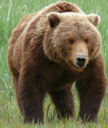

In [10]:
im = Image.open(dest)
im.to_thumb(128,128)

In [13]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [12]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} bear')
        download_images(dest, urls=results)

In [14]:
fns = get_image_files(path)
fns

(#549) [Path('bears/grizzly/c53a79a4-53a7-4b23-a132-7a375886a338.jpeg'),Path('bears/grizzly/292a134a-6998-4319-a1d6-77f0213aa31e.jpg'),Path('bears/grizzly/7d7c77b3-70a2-4a13-b913-0d1d5acc1e04.jpg'),Path('bears/grizzly/0e3dedd2-2463-4dfc-88e1-f89b1dd4a824.jpg'),Path('bears/grizzly/24d617c8-a929-47a4-b278-c93752de8185.jpg'),Path('bears/grizzly/f5ca6ebe-4554-4c26-a7c6-d5c5d40f75a8.jpg'),Path('bears/grizzly/f64cf695-0280-47f7-8d85-cf2d5d38acaa.jpg'),Path('bears/grizzly/cace348f-cb9d-4d2f-b4d2-fb0a709d1380.jpeg'),Path('bears/grizzly/c05aa9a0-0e01-47ca-a49b-6c19354b83d9.JPG'),Path('bears/grizzly/c824fe61-6f33-4a45-8bc0-44f634e6ad46.jpg')...]

In [15]:
failed = verify_images(fns)
failed

(#29) [Path('bears/grizzly/c05aa9a0-0e01-47ca-a49b-6c19354b83d9.JPG'),Path('bears/grizzly/de2a19c8-f2a0-4d60-89e5-2b7671839350.jpg'),Path('bears/grizzly/ea3d4a29-385d-41ee-82f9-3433a9ad592b.jpg'),Path('bears/grizzly/066edf96-a3fa-401a-a6c3-3bed4c81027c.JPG'),Path('bears/grizzly/4dded8a1-8cf7-4a54-8c86-9c50924b28be.jpg'),Path('bears/grizzly/cc9c2630-384b-462e-8437-b71793ff24f5.jpg'),Path('bears/grizzly/bb91b44a-05d1-4ba0-9871-9023251e37f8.jpg'),Path('bears/grizzly/269651e1-417c-4f11-a270-aebd840e133f.jpg'),Path('bears/grizzly/9f59fd37-72f8-4c3c-bab6-4100c3a6cab8.JPG'),Path('bears/grizzly/698e1252-a4ee-4a40-868d-5112ee9e31d3.jpg')...]

In [16]:
failed.map(Path.unlink);

**FROM DATA TO DATALOADERS**

In [17]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [18]:
dls = bears.dataloaders(path)

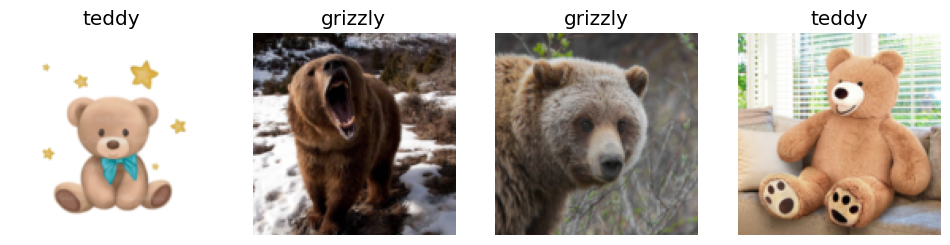

In [19]:
dls.valid.show_batch(max_n=4, nrows=1)

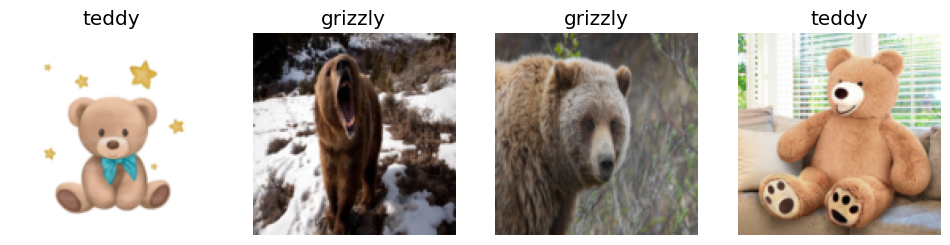

In [20]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

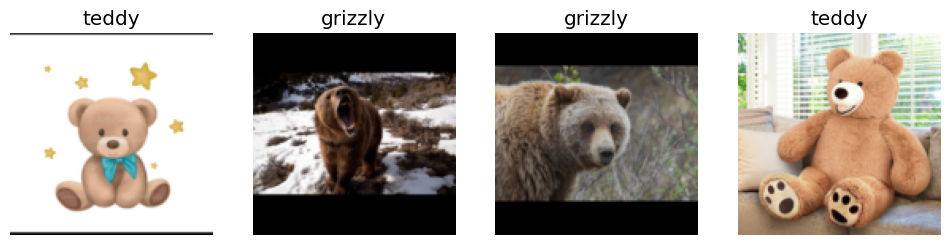

In [21]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

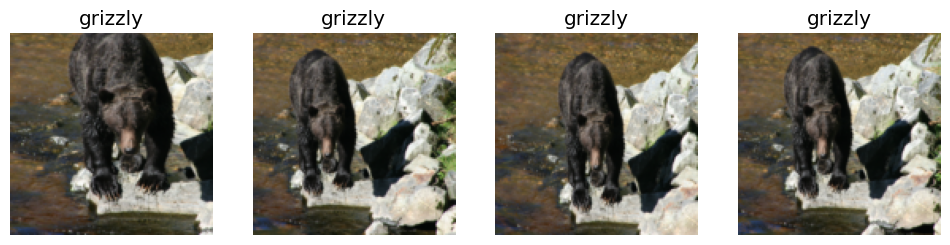

In [22]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

**DATA AUGMENTATION**

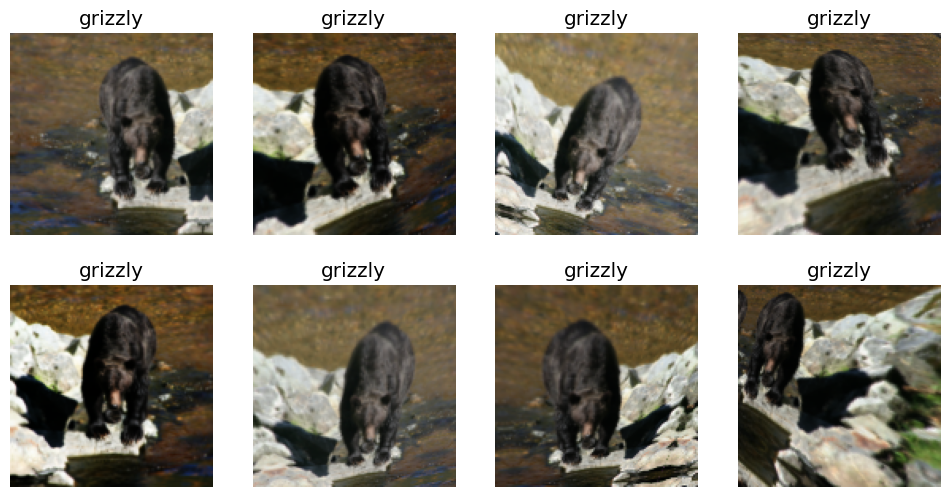

In [23]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

**TRAINING YOUR MODEL**

In [24]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [25]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 111MB/s] 


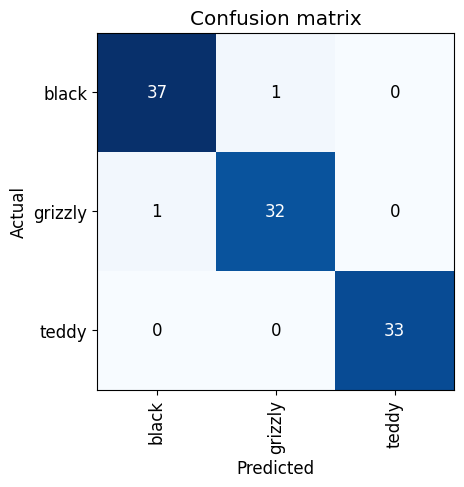

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

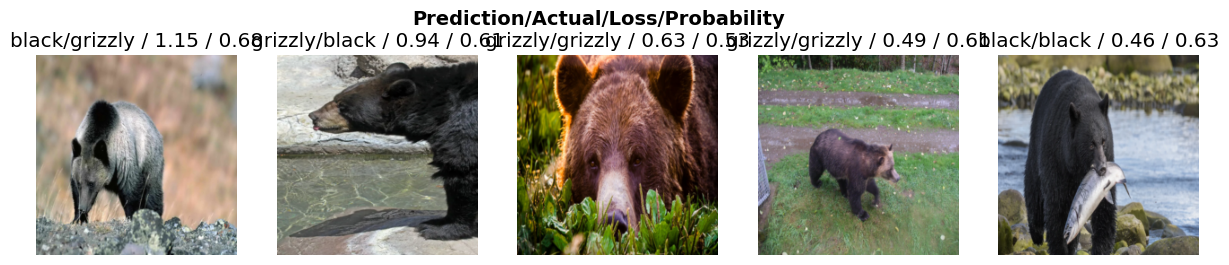

In [27]:
interp.plot_top_losses(5, nrows=1)

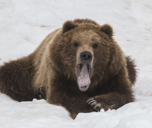

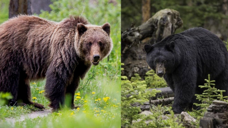

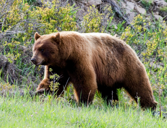

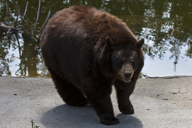

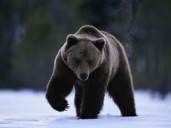

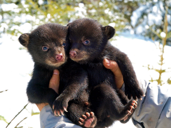

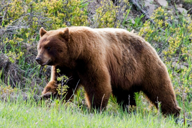

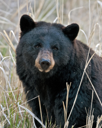

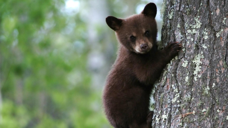

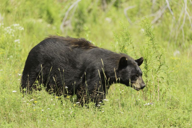

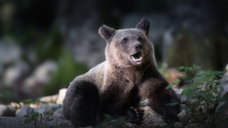

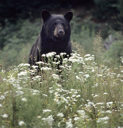

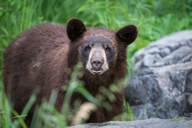

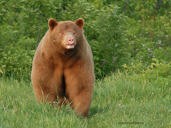

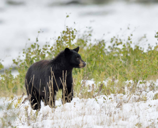

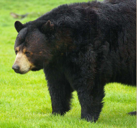

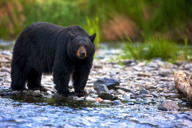

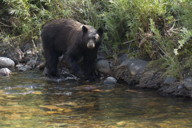

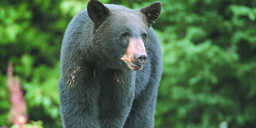

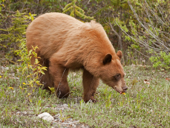

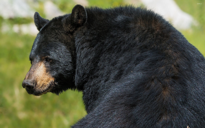

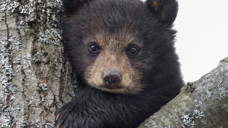

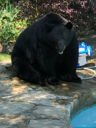

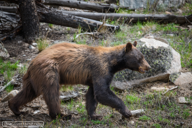

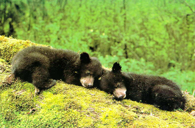

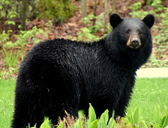

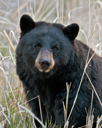

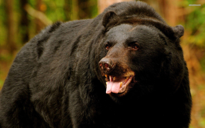

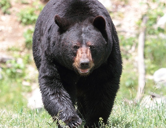

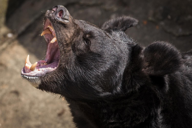

In [28]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [29]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

**TURNING YOUR MODEL TO ONLINE APPLICATION**

In [30]:
learn.export()

In [31]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [32]:
learn_inf = load_learner(path/'export.pkl')

In [33]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([2.2076e-04, 9.9977e-01, 1.1083e-05]))

In [34]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

**CREATING A NOTEBOOK APP FROM THE MODEL**

In [40]:
# Install ipywidgets if not already installed
!pip install ipywidgets
import ipywidgets as widgets

In [21]:
!pip install voila

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 29.7 MB/s eta 0:00:0000:0100:01
